# Mount dysk konta google do notebooka

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
!pip install mne
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 20.5 MB/s eta 0:00:00


---
# Legenda:

<font color="lightblue">▬ </font>Cytaty z artykułu<br>
<font color="pink">▬ </font>Implementacja<br>

---

# <font color="lightgreen"> Architektura modeli</font>

(Wszystko w kursywie koloru niebieskiego jest z artykułu.)

<font color="lightblue">*The network consisted of Transformer
 modules as well as operations of Positional Embedding.
 We also designed methods that combined the CNN module
 and the Transformer module. CNN was included because
 of its good properties for feature representation [5].*</font>

 <font color="lightblue">*In the implementation, we built a total of **five** Transformer-based
 models in which two models only relied on the Transformer
 without including the CNN and three models used network
 architecture of combined CNN and Transformer. After the
 CNN and the Transformer modules, we included a fully
connected layer.*

*In this study, we employed **h = 8 parallel attention layers
 (so-called 8 attention heads)**, and solely embedded the encoder
 part of Transformer into the EEG classification.*</font>

---

 <font color="lightblue">*The Transformer module had two submodules. The
 first submodule included a multi-head attention layer followed
 by a normalization layer. The second submodule included a
 position-wise fully connected feed-forward layer followed by
 a normalization layer. The residual connection was employed
 around each of the two submodules.*</font>


<img src="https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/Transformer-neural-network-12.png" width="400">

# <font color="pink"> Moduł Transformera</font>


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


"""
d_model -> wymiar wektorów osadzonych (embeddingów)
ReLU    -> to funkcja aktywacji (tutorial: https://www.youtube.com/watch?v=68BZ5f7P94E)
norm1 i norm2 -> To są warstwy Layer Normalization, normalizują dane na poziomie każdej próbki

"""
class TransformerBlock(nn.Module):
  def __init__(self, d_model, nhead):
    super(TransformerBlock, self).__init__()
    self.attn = nn.MultiheadAttention(d_model, nhead, dropout=0.3)

    # feed-forward layer
    self.ff = nn.Sequential(
        nn.Linear(d_model, 512),
        nn.ReLU(),
        nn.Linear(512, d_model)
    )

    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)

  def forward(self, x):

    # output, _ = attention(query=x, key=x, value=x)
    attn_output, _ = self.attn(x, x, x)

    x = self.norm1(x + attn_output)
    ff_output = self.ff(x)
    x = self.norm2(x + ff_output)
    return x


# <font color="pink"> Positional encoding</font>





In [ ]:
class PositionalEncoding(nn.Module):
  # 1000, bo dla 3s mamy 480 próbek, dla 6s 960 (physionet) 3000 bc of stft and cnn
  def __init__(self, d_model, max_len=3000):
    super(PositionalEncoding, self).__init__()
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
    # For even indices (dimension 2i):
    # PE(pos, 2i) = sin(pos / (10000^(2i / d_model))) ---> (10000^(2i / d_model)) === div_term
    pe[:, 0::2] = torch.sin(position * div_term)
    # For odd indices (dimension 2i+1):
    # PE(pos, 2i+1) = cos(pos / (10000^(2i / d_model)))
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe', pe)

  def forward(self, x):
    return x + self.pe[:x.size(0), :, :]

In [ ]:
class LearnedPositionalEncoding(nn.Module):
    def __init__(self, num_positions, d_model):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.zeros(num_positions, 1, d_model))
        nn.init.xavier_uniform_(self.pos_embed)  # Proper init (they used random)

    def forward(self, x):
        return x + self.pos_embed[:x.size(0), :, :]


# EEG Transformer Models with Feature Extraction
This notebook contains implementations of EEG classification models using various Transformer-based architectures and feature extraction methods including STFT, Wavelet Transform, CSP, and CNN.

In [ ]:
import numpy as np
from mne.decoding import CSP
import pywt
import torchvision
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler


In [ ]:
N_FFT = 128
#N_FFT = 32
HOP_LENGTH = 32
#HOP_LENGTH = 16
WAVELET_TYPE = 'coif3'
LEVEL_COUNT = 3
NUM_COMP = 6
PATCH_SIZE = 16
WINDOW_SIZE = 6

class FeatureExtractor(nn.Module):
    def __init__(self, model_class_name, method='raw', wavelet=WAVELET_TYPE, level=LEVEL_COUNT, n_csp_components=NUM_COMP):
        super(FeatureExtractor, self).__init__()
        self.model_class_name = model_class_name
        self.method = method
        self.wavelet = wavelet
        self.level = level
        self.n_csp_components = n_csp_components

        if method == 'cnn':
              if "Temporal" in self.model_class_name:
                  self.cnn = nn.Sequential(
                      nn.Conv2d(1, 64, kernel_size=(64, 1), padding='same'),
                      nn.ReLU(),
                      nn.AvgPool2d((1, 8))
                  )
              elif "Spatial" in self.model_class_name:
                  self.cnn = nn.Sequential(
                      nn.Conv2d(1, 64, kernel_size=(1, 16), padding='same'),
                      nn.ReLU(),
                      nn.AvgPool2d((1, 32)),
                      nn.Conv2d(64, 64, kernel_size=(1, 15), padding='same'),
                      nn.ReLU()
                  )

        elif method == 'csp':
            self.csp = CSP(n_components=n_csp_components, reg=0.1, log=True, norm_trace=True)
            self.csp_fitted = False


    def fit(self, x, y):
        if self.method == 'csp':
            x_np = x.squeeze(1).cpu().numpy().astype(np.float64)  # (B, C, T)

            # Normalize (z-centering + standardization per channel)
            x_np -= x_np.mean(axis=2, keepdims=True)
            x_np /= (x_np.std(axis=2, keepdims=True) + 1e-6)

            self.csp.fit(x_np, y)
            self.csp_fitted = True
            self.n_csp_components_actual = self.csp.filters_.shape[0]

    def forward(self, x):
        if x.ndim == 3:
            # x: (B, 1, C, T)
            x = x.unsqueeze(1)

        if self.method == 'raw':
            if x.ndim == 3:
                # x: (B, 1, C, T)
                x = x.unsqueeze(1)
            return x

        elif self.method == 'cnn':
            return self.cnn(x)

        elif self.method == 'stft':
            B, _, C, T = x.shape
            x = x.squeeze(1)  # (B, C, T)
            n_fft = N_FFT
            hop_length = HOP_LENGTH
            window = torch.hann_window(n_fft, device=x.device)

            # Reshape for batch STFT: merge batch and channel dims
            x = x.permute(0, 1, 2).reshape(B * C, T)  # (B*C, T)

            stft = torch.stft(
                x, n_fft=n_fft, hop_length=hop_length,
                window=window, return_complex=True
            )                                                   # shape: (B*C, F, T')

            F_dim, T_dim = stft.shape[-2], stft.shape[-1]

            stft = stft.view(B, C, F_dim, T_dim)                # Reshape back to (B, C, F, T')
            stft = torch.stack([stft.real, stft.imag], dim=1)   # Separate real and imag parts as extra channel (B, 2, C, F, T')

            return stft                                         # shape: (B, 2, C, F, T')

        elif self.method == 'wavelet':
            B, _, C, T = x.shape
            features = []
            for b in range(B):
                per_channel = []
                for c in range(C):
                    coeffs = pywt.wavedec(x[b, 0, c, :].cpu().numpy(), self.wavelet, level=self.level)
                    coeffs = [torch.tensor(c, dtype=torch.float32, device=x.device) for c in coeffs]
                    coeffs = torch.nn.utils.rnn.pad_sequence(coeffs, batch_first=True)  # (Levels, T_sub)
                    per_channel.append(coeffs)
                per_channel = torch.stack(per_channel)          # (C, Levels, T_sub)
                features.append(per_channel)
            x_out = torch.stack(features)                       # (B, C, Levels, T_sub)
            return x_out

        elif self.method == 'csp':
            # patching uzywany np. w DOI: 10.1109/TNSRE.2023.3297654
            if not self.csp_fitted:
                raise RuntimeError("CSP not fitted. Call .fit(X, y) first.", self.model_class_name)

            x = x.squeeze(1)  # (B, C, T)
            x = x - x.mean(dim=2, keepdim=True)
            x = x / (x.std(dim=2, keepdim=True) + 1e-6)

            x_np = x.detach().cpu().numpy().astype(np.float64)  # (B, C, T)
            x_np = x_np.transpose(0, 2, 1)                      # (B, T, C)

            filters = self.csp.filters_                         # (n_channels, n_channels)
            n_csp = self.n_csp_components

            # ===== Take n_csp//2 best and n_csp//2 worst filters =====
            filters = np.concatenate([filters[:n_csp//2, :], filters[-n_csp//2:, :]], axis=0)  # shape: (n_csp, C)

            x_csp = np.matmul(x_np, filters.T)   # (B, T, n_csp)
            x_csp = torch.tensor(x_csp.transpose(0, 2, 1), dtype=torch.float32, device=x.device)  # (B, n_csp, T)

            # ===== Patchify for Transformer =====
            patch_size = PATCH_SIZE
            B, n_csp, T = x_csp.shape
            num_patches = T // patch_size

            x_csp = x_csp[:, :, :num_patches * patch_size]
            x_csp = x_csp.unfold(dimension=2, size=patch_size, step=patch_size)   # (B, n_csp, num_patches, patch_size)
            x_csp = x_csp.permute(0, 2, 1, 3)                                     # (B, num_patches, n_csp, patch_size)
            x_csp = x_csp.flatten(2)                                              # (B, num_patches, n_csp * patch_size) -> tokens

            return x_csp


        else:
            raise ValueError(f"Unknown feature extraction method: {self.method}")


In [ ]:
def precompute_subject_features(model_class_name, subject_data_dict, feature_method, wavelet=WAVELET_TYPE, level=LEVEL_COUNT):
    """Return new dict with precomputed features (STFT or wavelet)."""
    print(f"Precomputing {feature_method} features for all subjects...")
    extractor = FeatureExtractor(model_class_name=model_class_name,method=feature_method, wavelet=wavelet, level=level)
    new_subject_data = {}

    for subj, (X, y) in subject_data_dict.items():
        with torch.no_grad():
            X_feat = extractor(torch.tensor(X).unsqueeze(1)).cpu().numpy()
        new_subject_data[subj] = (X_feat, y)
        print(f"[DEBUG] X_feat shape: {X_feat.shape}")  # Should be [freq_bins, time_frames]

    return new_subject_data


# <font color="pink"> Spatial Transformer</font>





In [ ]:
# Learns dependencies between channel
class SpatialTransformer(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=8, num_classes=2, feature_method='raw', feature_extractor=None):
        super(SpatialTransformer, self).__init__()
        self.feature_method = feature_method

        if feature_method in ['raw', 'cnn', 'stft']:
            self.feature_extractor = FeatureExtractor(model_class_name=self.__class__.__name__, method=feature_method)
        elif feature_method == 'csp':
            self.feature_extractor = feature_extractor
        else:
            self.feature_extractor = None

        self.embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=128)
        # self.pos_encoder = LearnedPositionalEncoding(num_positions=64, d_model=d_model)
        self.transformer = nn.Sequential(
            TransformerBlock(d_model, nhead),
            TransformerBlock(d_model, nhead),
            TransformerBlock(d_model, nhead)
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):  # x shape: (B, 1, C, T)
        if self.feature_extractor is not None and self.feature_method != 'raw':
            x = self.feature_extractor(x)

        # (channels = sequence dimension)
        if self.feature_method == 'raw':
            x = x.squeeze(1).permute(1, 0, 2) # (channels, batch, time)

        elif self.feature_method == 'cnn':
            # CNN output: (B, 64, C, T)
            B, F, C, T = x.shape
            x = x.mean(dim=3)                 # → (B, 64, C)
            x = x.permute(2, 0, 1)            # (C, B, features)

        elif self.feature_method == 'csp':
            # x: (B, num_patches, n_csp * path_size)
            x = x.permute(1, 0, 2)            # (num_patches, B, n_csp * path_size)

        elif self.feature_method == 'stft':
            B, C2, C, F, T_ = x.shape
            x = x.permute(0, 2, 1, 3, 4)      # (B, C, 2, F, T)
            x = x.reshape(B, C * C2, F * T_)  # (B, 128, 1040)
            x = x.permute(1, 0, 2)            # (128, B, 1040)

        elif self.feature_method == 'wavelet':
            # x: (B, C, Levels, T_sub)
            B, C, L, T_sub = x.shape
            x = x.reshape(B, C, L * T_sub)    # flatten Levels and T_sub into features
            x = x.permute(1, 0, 2)            # (C, B, features)

        else:
            raise ValueError(f"Unsupported feature method: {self.feature_method}")

        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=0)
        return self.fc(x)


In [ ]:
# Transformer learns relationships between time points
class TemporalTransformer(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=8, num_classes=2, feature_method='raw', feature_extractor=None):
        super(TemporalTransformer, self).__init__()
        self.feature_method = feature_method

        if feature_method in ['raw', 'cnn', 'stft']:
            self.feature_extractor = FeatureExtractor(model_class_name=self.__class__.__name__, method=feature_method)
        elif feature_method == 'csp':
            self.feature_extractor = feature_extractor
        else:
            self.feature_extractor = None  # No extractor needed

        self.embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        # self.pos_encoder = LearnedPositionalEncoding(num_positions=481, d_model=d_model)
        self.transformer = nn.Sequential(
            TransformerBlock(d_model, nhead),
            TransformerBlock(d_model, nhead),
            TransformerBlock(d_model, nhead)
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):  # x shape: (batch, 1, channels, time)
        if self.feature_extractor is not None:
            x = self.feature_extractor(x)

        # (time = sequence dimension)
        if self.feature_method == 'raw':
          x = x.squeeze(1).permute(2, 0, 1) # (time, batch, channels)

        elif self.feature_method == 'cnn':
            # x: (B, 64, C, T)
            B, F, C, T = x.shape
            x = x.mean(dim=2)               # → (B, 64, T_new)
            x = x.permute(2, 0, 1)          # (time, batch, features)

        elif self.feature_method == 'csp':
            # x: (B, n_csp * aptch_size, num_patches)
            x = x.permute(2,0,1) # (T, B, k)

        elif self.feature_method == 'stft':
            # x: (B, 2, C, F, T')
            B, C2, C, F, T_ = x.shape
            x = x.permute(0, 4, 2, 3, 1).reshape(B, T_, C * F * C2).permute(1, 0, 2)  # (T, B, features)

        elif self.feature_method == 'wavelet':
            # x: (B, C, Levels, T_sub)
            B, C, L, T_sub = x.shape
            x = x.permute(3, 0, 1, 2)       # (T_sub, B, C, Levels)
            x = x.reshape(T_sub, B, C * L)  # flatten channel and levels to features dimension

        else:
            raise ValueError(f"Unsupported feature method: {self.feature_method}")

        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=0)
        return self.fc(x)

# <font color="pink"> Temporal Transformer</font>









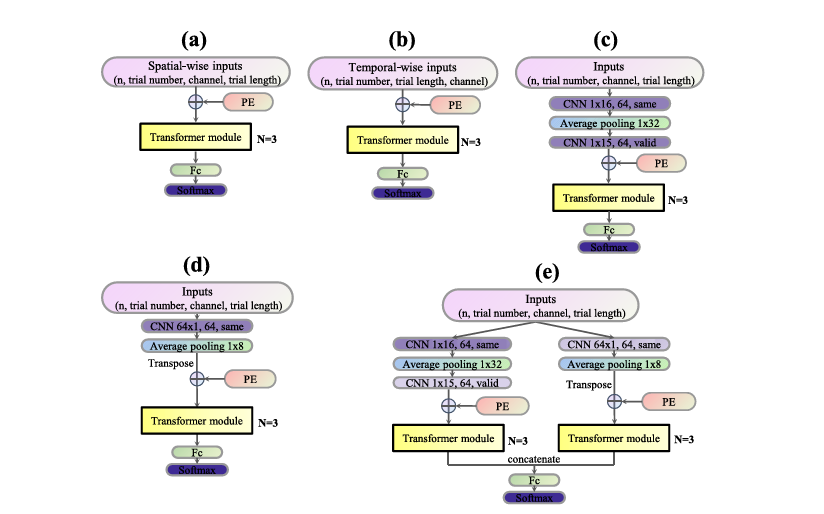

# <font color="pink"> Spatial CNN Transformer</font>


  <font color="lightblue">*In the spatial implementation of the CNN + Transformer
 model (s-CTrans, Fig. 3c), the CNN module included two
 convolutional layers and one average pooling layer. In the first
 convolutional layer, we used 64 kernels with the size of 1 × 16
 (channel × time points) to extract EEG temporal information,
 and adopted the SAME padding. The average pooling layer
 had the pooling size of 1 × 32. The second convolutional
 layer used 64 kernels with the size of 1 × 15, and adopted
 the VALID padding*</font>







In [ ]:
# Uses CNN to help extract temporal features per channel, then model channel relations
class SpatialCNNTransformer(nn.Module):
    def __init__(self, input_size, d_model=128, nhead=8, num_classes=2, feature_method='raw', feature_extractor=None):
        super(SpatialCNNTransformer, self).__init__()
        self.input_size = input_size
        self.feature_method = feature_method

        if feature_extractor != None or feature_extractor == 'csp':
            self.feature_extractor = feature_extractor
        elif feature_method in ['raw', 'cnn','stft']:
            self.feature_extractor = FeatureExtractor(model_class_name=self.__class__.__name__, method=feature_method)
        else:
            self.feature_extractor = None

        self.cnn, self.embedding = self._build_feature_layers(feature_method, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Sequential(*[TransformerBlock(d_model, nhead) for _ in range(3)])
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        if self.feature_extractor:
            x = self.feature_extractor(x)

        if self.feature_method == 'raw':   # x shape: (B, 1, C, T)
            x = self.cnn(x)
            if x.shape[3] == 1:
                x = x.squeeze(3).permute(2, 0, 1)
            else:
                x = x.mean(dim=-1)  # Reduce time dimension → [32, 64, 64]
                x = x.permute(2, 0, 1)  # → [C=64, B=32, F=64]


        elif self.feature_method == 'cnn':
            B, Feat, C, T = x.shape
            x = x.permute(2, 0, 3, 1).reshape(C, B, T * Feat)  # (C, B, F*T)

        elif self.feature_method == 'csp':
            B, num_patches, token_dim = x.shape  # token_dim = n_csp * patch_size
            x = x.view(B, PATCH_SIZE, -1)  # (B, PATCH_SIZE, num_patches * n_csp)
            x = self.cnn(x)                # Apply 1D CNN
            x = x.view(B, -1)              # Flatten
            x = x.unsqueeze(0)             # (1, B, d_model) for transformer

        elif self.feature_method == 'stft':
            x = self.cnn(x)             # (B, 64, C, H = frequency dimension, W = time frames)
            B, FeatMap, C, H, W = x.shape
            x = x.permute(2, 0, 3, 4, 1).reshape(C, B, -1)  # (C, B, H*W*FeatMap)

        elif self.feature_method == 'wavelet':
            # x: (B, C, L, T_sub = Time steps after wavelet transform (per level))
            B, C, L, T_sub = x.shape
            x = x.reshape(B, 1, C , 1, T_sub* L)
            x = self.cnn(x)             # CNN designed for (B, 1, C, T)
            x = x.squeeze(3)            # removes dim 3 (H), shape: (B, F, C, T_out)
            x = x.permute(2, 0, 1, 3)   # (C, B, F, T_out)
            x = x.reshape(C, B, -1)     # flatten features = F * T_out

        else:
            raise ValueError(f"Unsupported feature method: {self.feature_method}")

        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=0)
        return self.fc(x)


    def _build_feature_layers(self, feature_method, d_model):
        """
        Build CNN and embedding layers based on feature_method.
        """
        if feature_method == 'raw':
            # Input: (B, 1, C, T)
            cnn = nn.Sequential(
                nn.Conv2d(1, 64, (1, 16), padding='same'),
                nn.ReLU(),
                nn.AvgPool2d((1, 32)),
                nn.Conv2d(64, 64, (1, 15), padding='valid'),
                nn.ReLU()
            )
            embedding = nn.Linear(64, d_model)  # Precomputed flattened size

        elif feature_method == 'csp':
            # Input: (B, k, T)
            cnn = nn.Sequential(
                nn.Conv1d(in_channels=PATCH_SIZE, out_channels=64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv1d(64, 128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(output_size=32)
            )
            with torch.no_grad():
                dummy_input = torch.zeros(1, PATCH_SIZE, NUM_COMP * PATCH_SIZE)
                out = cnn(dummy_input)
            flat_feat_size = out.shape[1] * out.shape[2]
            embedding = nn.Linear(flat_feat_size, d_model)

        elif feature_method == 'stft':
            # Input: (B, 2, C, F, T')
            cnn = nn.Sequential(
                nn.Conv3d(2, 32, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
                nn.ReLU(),
                nn.AvgPool3d((1, 2, 2)),
                nn.Conv3d(32, 64, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
                nn.ReLU(),
                nn.AvgPool3d((1, 2, 2))
            )
            with torch.no_grad():
                dummy_input = torch.zeros(1, 2, 64, 65, 16)  # (B=1, 2, C=64, F=65, T'=16)
                out = cnn(dummy_input)                    # Output: (1, 64, C, H, W)
            _, FeatMap, C, H, W = out.shape
            flat_feat_size = H * W * FeatMap
            embedding = nn.Linear(flat_feat_size, d_model)

        elif feature_method == 'wavelet':
            # Input: (B, CL, T)
            cnn = nn.Sequential(
                nn.Conv3d(1, 32, kernel_size=(1, 1, 3), padding=(0, 0, 1)),
                nn.ReLU(),
                nn.AvgPool3d((1, 1, 2)),
                nn.Conv3d(32, 64, kernel_size=(1, 1, 3), padding=(0, 0, 1)),
                nn.ReLU(),
                nn.AvgPool3d((1, 1, 2))
            )
            with torch.no_grad():
                dummy_input = torch.zeros(1, 64, self.input_size)  # (B=1, CL=256, T=244)
                dummy_input = dummy_input.unsqueeze(1).unsqueeze(3)  # (1, 1, 256, 1, 244)
                out = cnn(dummy_input)                    # Output: (1, 64, 256, 1, T_sub)
            _, FeatMap, CL, _, T_sub = out.shape
            flat_feat_size = FeatMap * T_sub
            embedding = nn.Linear(flat_feat_size, d_model)

        elif feature_method == 'cnn':
            # Input: (B, 1, C, T)
            cnn = nn.Sequential(
                nn.Conv2d(1, 64, (1, 16), padding='valid'),
                nn.ReLU(),
                nn.AvgPool2d((1, 32)),
                nn.Conv2d(64, 64, (1, 15)),
                nn.ReLU()
            )
            embedding = nn.Linear(960, d_model)  # Precomputed flattened size

        else:
            cnn = None
            embedding = nn.Linear(input_size, d_model)

        return cnn, embedding


# <font color="pink"> Temporal CNN Transformer</font>

  <font color="lightblue">*In the temporal implementation of the CNN + Transformer
 model (t-Ctrans, Fig 3d), the CNN module included one
 convolutional layer and one average pooling layer. The con
volutional layer used 64 kernels with the size of 64 × 1(chan
nel × time points) to extract EEG spatial information, and
 adopted the SAME padding. The average pooling layer had
 the pooling size of 1 × 8. After the average pooling layer,
 we transposed the features.*</font>


In [ ]:
# Uses CNN to help extract spatial features per time point, then model time dynamics
class TemporalCNNTransformer(nn.Module):
    def __init__(self, input_size, d_model=128, nhead=8, num_classes=2, feature_method='raw', feature_extractor=None):
        super(TemporalCNNTransformer, self).__init__()
        self.feature_method = feature_method
        self.input_size = input_size

        if feature_extractor != None or feature_extractor == 'csp':
            self.feature_extractor = feature_extractor
        elif feature_method in ['raw', 'cnn', 'csp', 'stft']:
            self.feature_extractor = FeatureExtractor(model_class_name=self.__class__.__name__, method=feature_method) if feature_method != 'none' else None
        else:
            self.feature_extractor = None

        self.cnn, self.embedding = self._build_feature_layers(feature_method, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Sequential(*[TransformerBlock(d_model, nhead) for _ in range(3)])
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        if self.feature_extractor:
            x = self.feature_extractor(x)

        if self.feature_method == 'raw':  # x shape: (B, 1, C, T)
            x = self.cnn(x)               # → (B, 64, 1, T_new)
            x = x.mean(dim=2)             # → (B, 64, T_new)
            x = x.permute(2, 0, 1)        # (time, batch, features)

        elif self.feature_method == 'cnn':
            x = self.cnn(x)               # (B, 64, C', T')
            x = x.mean(dim=2)             # → (B, 64, T)
            x = x.permute(2, 0, 1)        # (T, B, 64)

        elif self.feature_method == 'csp':          # x shape: (B, num_patches, n_csp * patch_size)
            x = x.unsqueeze(1).permute(0, 1, 3, 2)  # (B, 1, n_csp * patch_size, num_patches)
            x = self.cnn(x)
            x = x.mean(dim=2)             # average over spatial dim (num_patches)
            x = x.permute(2, 0, 1)        # (T = n_csp * patch_size, B, features)

        elif self.feature_method == 'stft':
            x = self.cnn(x)               # (B, 64, C, H, W)
            B, FeatMap, C, H, W = x.shape
            x = x.permute(0, 4, 2, 3, 1).reshape(B, W, -1)  # (B, T', C*H*F)
            x = x.permute(1, 0, 2)        # (T', B, C*H*F)

        elif self.feature_method == 'wavelet':
            B, C, L, T_sub = x.shape
            x = x.reshape(B, 1, C * L, 1, T_sub)  # (B, 1, CL, 1, T_sub)
            x = self.cnn(x)               # (B, F, CL, H, T_sub)
            B, FeatMap, CL, H, T_sub = x.shape
            x = x.permute(0, 4, 2, 3, 1).reshape(B, T_sub, -1)  # (B, T_sub, flat_feat_size)
            x = x.permute(1, 0, 2)        # (T_sub, B, flat_feat_size)

        else:
            raise ValueError(f"Unsupported feature method: {self.feature_method}")

        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=0)
        return self.fc(x)

    def _build_feature_layers(self, feature_method, d_model):
        """
        Build CNN and embedding based on feature_method.
        """
        if feature_method == 'raw':
            # Input: (B, 1, C, T)
            cnn = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=(64, 1), padding='same'),
                nn.ReLU(),
                nn.AvgPool2d((1, 8))
            )
            embedding = nn.Linear(64, d_model)

        elif feature_method == 'csp':
            # Input: (B, 1, k, T)
            cnn = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=(4, 1)),  # → (B, 32, 1, T)
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=(3, 1)), # → (B, 64, 1, T)
                nn.ReLU()
            )
            with torch.no_grad():
                dummy_input = torch.zeros(1, 1,  NUM_COMP * PATCH_SIZE, self.input_size)
                out = cnn(dummy_input)
            flat_feat_size = out.shape[1]
            embedding = nn.Linear(flat_feat_size, d_model)

        elif feature_method == 'stft':
            # Input: (B, 2, C, F, T')
            cnn = nn.Sequential(
                nn.Conv3d(2, 32, kernel_size=(1, 3, 3), padding=(0, 1, 1)),  # → (B, 32, C, F, T')
                nn.ReLU(),
                nn.AvgPool3d(kernel_size=(1, 2, 2)),
                nn.Conv3d(32, 64, kernel_size=(1, 3, 3), padding=(0, 1, 1)), # → (B, 64, C, F, T')
                nn.ReLU(),
                nn.AvgPool3d(kernel_size=(1, 2, 2))
            )
            with torch.no_grad():
                dummy_input = torch.zeros(1, 2, 64, 65, 16)   # (B=1, 2, C=64, F=65, T'=16)
                out = cnn(dummy_input)                        # Output: (1, 64, C, H, W)
            B, FeatMap, C, H, W = out.shape
            flat_feat_size = FeatMap * C * H
            embedding = nn.Linear(flat_feat_size, d_model)

        elif feature_method == 'wavelet':
            # Input: (B, 1, coeff_len, 1, T')
            cnn = nn.Sequential(
                nn.Conv3d(1, 16, kernel_size=(1, 1, 3), padding=(0, 0, 1)), # → (B, 16, coeff_len, 1, T')
                nn.ReLU(),
                nn.AvgPool3d(kernel_size=(1, 1, 2)),
                nn.Conv3d(16, 32, kernel_size=(1, 1, 3), padding=(0, 0, 1)),# → (B, 32, coeff_len, 1, T')
                nn.ReLU(),
                nn.AvgPool3d(kernel_size=(1, 1, 2))
            )
            with torch.no_grad():
                dummy_input = torch.zeros(1, 1, 256, 1, self.input_size)  # (B=1, 1, CL=256, 1, T'=244)
                out = cnn(dummy_input)                        # Output: (1, 32, CL, 1, T')
            B, FeatMap, CL, H, T_sub = out.shape
            flat_feat_size = FeatMap * CL * H
            embedding = nn.Linear(flat_feat_size, d_model)

        elif feature_method == 'cnn':
            # Input: (B, 64, C, T)
            cnn = nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=(16, 1), padding='same'), # → (B, 64, C, T)
                nn.ReLU(),
                nn.AvgPool2d((1, 4))
            )
            embedding = nn.Linear(64, d_model)

        else:
            cnn = None
            embedding = nn.Linear(64, d_model)

        return cnn, embedding



# <font color="pink"> FusionCNNTransformer</font>

In [ ]:
# Combine both spatial and temporal CNN Transformer
class FusionCNNTransformer(nn.Module):
    def __init__(self, input_size, d_model=128, nhead=8, num_classes=2, feature_method='raw', feature_extractor=None):
        super(FusionCNNTransformer, self).__init__()

        self.feature_extractor = feature_extractor
        if feature_method in ['wavelet', 'csp']:
            spatial_input_size, temporal_input_size = input_size
        else:
            spatial_input_size = temporal_input_size = input_size


        self.s_cnn = SpatialCNNTransformer(spatial_input_size, d_model, nhead, num_classes, feature_method, feature_extractor=self.feature_extractor)
        self.t_cnn = TemporalCNNTransformer(temporal_input_size, d_model, nhead, num_classes, feature_method, feature_extractor=self.feature_extractor)
        self.fc = nn.Linear(num_classes * 2, num_classes)

    def forward(self, x):
        spatial_out = self.s_cnn(x)
        temporal_out = self.t_cnn(x)
        fusion = torch.cat((spatial_out, temporal_out), dim=1)
        return self.fc(fusion)

---

# <font color="pink"> Przygotowanie danych do treningu w PyTorch</font>

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
  def __init__(self, X, y, cnn_mode=False, feature_method='raw'):
    self.X = torch.tensor(X, dtype=torch.float32)

    if cnn_mode and feature_method == 'raw':
      self.X = self.X.unsqueeze(1)
    self.y = torch.tensor(y, dtype=torch.long)

  def __len__(self):
      return len(self.X)
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]



*Training Parameter Settings:*
<font color="lightblue">
* *Empirically, the number of
 head in each multi-head attention layer was set to 8 [25].*
* *The dropout rate was set to 0.3.*
* *The parameter of the position-wise fully connected feed-forward layer with a ReLU activation was set to 512.*
* *The weight attenuation was 0.0001.*
* *All the models used the Adam optimizer. The training epoch was set
 to 50.*
* *The EEG data were transformed into 3D tensors (N, C, T), where N is the number of trials, C is the number of channels, and T is the time points.*
* *In our Transformer-based models,
 we set dk = dv = 64, which was the same size as EEG
 channel numbers.*</font>



In [ ]:
import mne
import os
import csv
import numpy as np
from torchmetrics.classification import Accuracy
from sklearn.metrics import confusion_matrix

dataset = "Physionet"
preprocessed_data_dir = f"/content/drive/My Drive/EEG_Data/{dataset}"
d_model = 64
nhead = 8
num_classes = 2
batch_size = 32
num_epochs = 50
weight_decay=1e-4
cnn_models = {"SpatialCNNTransformer", "TemporalCNNTransformer", "FusionCNNTransformer"}

def load_subject_data(file_path) ->tuple[np.ndarray, np.ndarray]:
    epochs = mne.read_epochs(file_path, preload=True)
    """
    Number of epochs, channels, n_times -> Liczba punktów czasowych w jednym epizodzie EEG (czyli długość sygnału w czasie).
                                          Dla danych 3-sekundowych:
                                          EEG było próbkowane z częstotliwością 160 Hz

                                          3 sekundy × 160 Hz = 480 punktów

                                          Więc: n_times = 480

                                          Dla danych 6-sekundowych:
                                          6 sekundy × 160 Hz = 960 punktów

                                          Więc: n_times = 960
    """
    X = epochs.get_data()

    # Labels
    y = epochs.events[:, -1]

    # Labels should be numered 0, 1, 2 ...
    y = np.array([0 if label == 2 else 1 for label in y])
    return X, y


def train_model(model, train_loader, test_loader, device, lr):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=7e-4, weight_decay=1e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss)

        # Evaluate using evaluate_model_with_confusion:
        test_acc, _ = evaluate_model_with_confusion(model, test_loader, device)
        test_accuracies.append(test_acc * 100)  # Convert to percentage

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Test Acc: {test_acc:.4f}")

    return train_losses, test_accuracies


def evaluate_model(model, test_loader, device)-> float:
    acc = Accuracy(task='binary').to(device)
    model.eval()

    with torch.no_grad():
      for X_batch, y_batch in test_loader:
          X_batch, y_batch = X_batch.to(device), y_batch.to(device)
          output = model(X_batch)
          preds = torch.argmax(output, dim=1)
          acc.update(preds, y_batch)

    return acc.compute().item()

def evaluate_model_with_confusion(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = np.mean(all_preds == all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm


def save_results_to_csv(results, average_accuracy, model_class, feature_method, learning_rate, window_size = 6):
    filename_parts = [model_class.__name__, feature_method, str(learning_rate)]
    if feature_method == 'stft':
        filename_parts.insert(2, f"nfft{N_FFT}_hop{HOP_LENGTH}")
    elif feature_method == 'wavelet':
        filename_parts.insert(2, f"{WAVELET_TYPE}_levels{LEVEL_COUNT}")
    elif feature_method == 'csp':
        filename_parts.insert(2, f"numcomp{NUM_COMP}_patchsize{PATCH_SIZE}")

    output_csv = f"/content/drive/My Drive/EEG_Data/{dataset}/{window_size}s/fold_cross_subject_accuracies_{'_'.join(filename_parts)}.csv"

    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Fold", "Accuracy"])
        for i, acc in enumerate(results):
            writer.writerow([f"Fold {i + 1}", acc * 100])
        writer.writerow(["Average", average_accuracy * 100])

    print(f"Results saved to {output_csv}")
    return output_csv


def plot_metrics(avg_train_losses, avg_test_accuracies, output_csv):
    def plot_metric(values, ylabel, title, filename_suffix, color):
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, num_epochs + 1), values, label=ylabel, color=color)
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.savefig(filename_suffix)
        plt.show()

    loss_plot_path = output_csv.replace("fold_cross_subject_accuracies", "train_loss_curve").replace(".csv", ".png")
    acc_plot_path = output_csv.replace("fold_cross_subject_accuracies", "test_accuracy_curve").replace(".csv", ".png")

    plot_metric(avg_train_losses, 'Loss', 'Training Loss Across Folds', loss_plot_path, 'blue')
    plot_metric(avg_test_accuracies, 'Accuracy (%)', 'Test Accuracy Across Folds', acc_plot_path, 'green')


---

# <font color="pink">5fold cross-individual</font>





In [ ]:
def get_input_size(model_class_name, feature_method, raw_shape,
                   n_csp_components=NUM_COMP, cnn_out_channels=64,
                   n_fft=128, hop_length=32, wavelet_coeff_len=976):
    """
    Compute input size to embedding layer for Transformer models.
    Returns either int or tuple of (spatial_input_size, temporal_input_size) for fusion models.
    """

    model_class_name = model_class_name.lower()
    feature_method = feature_method.lower()

    if feature_method in ['raw', 'csp', 'stft', 'cnn']:
        _, C, T = raw_shape
    elif feature_method == 'wavelet':
        _, C, L, T_sub = raw_shape
    else:
        raise ValueError(f"Unsupported feature method: {feature_method}")

    def is_spatial(): return "spatial" in model_class_name
    def is_temporal(): return "temporal" in model_class_name
    def is_fusion(): return "fusion" in model_class_name
    def is_spatial_cnn(): return "spatialcnn" in model_class_name
    def is_temporal_cnn(): return "temporalcnn" in model_class_name

    if feature_method == 'raw':
        return T if is_spatial() else C if is_temporal() else T

    elif feature_method == 'csp':
        patch_size = PATCH_SIZE
        token_dim = n_csp_components * patch_size
        num_patches = T // patch_size

        spatial_size = token_dim
        temporal_size = num_patches
        return (spatial_size, temporal_size) if is_fusion() else (spatial_size if is_spatial() else temporal_size)

    elif feature_method == 'cnn':
        return cnn_out_channels if is_temporal() else T

    elif feature_method == 'stft':
        freq_bins = n_fft // 2 + 1
        padding = n_fft // 2
        stft_time_frames = 1 + (T + 2 * padding - n_fft) // hop_length

        spatial_size = freq_bins * stft_time_frames
        temporal_size = C * freq_bins * 2  # Real + Imag

        return (spatial_size, temporal_size) if is_fusion() else (spatial_size if is_spatial() else temporal_size)

    elif feature_method == 'wavelet':
        spatial_size = L * T_sub
        temporal_size = C * L

        if is_fusion():
            return (spatial_size, temporal_size)
        elif is_spatial_cnn():
            return wavelet_coeff_len
        elif is_temporal_cnn():
            return wavelet_coeff_len
        elif is_spatial():
            return spatial_size
        elif is_temporal():
            return temporal_size
        else:
            raise ValueError(f"Unknown model class: {model_class_name}")

    else:
        raise ValueError(f"Unsupported feature method: {feature_method}")


In [ ]:
def preload_subject_data(preprocessed_data_dir, window_size = 6,  max_subjects=None):
    """
    Preload EEG data for a limited number of subjects.

    Args:
        preprocessed_data_dir (str): Directory containing subject folders.
        max_subjects (int, optional): Max number of subjects to preload. If None, load all.

    Returns:
        dict: {subject_folder_name: (X, y)}
    """
    subject_data = {}
    all_subjects = sorted(os.listdir(preprocessed_data_dir))

    if max_subjects is not None:
        all_subjects = all_subjects[:max_subjects]  # Limit to first N subjects

    for subj_folder in all_subjects:
        subj_folder_path = os.path.join(preprocessed_data_dir, subj_folder)
        file_path = os.path.join(subj_folder_path, f"PA{subj_folder[1:]}-{window_size}s-epo.fif")
        if os.path.exists(file_path):
            X, y = load_subject_data(file_path)
            subject_data[subj_folder] = (X, y)
        else:
            print(f"[WARNING] File not found for {subj_folder}: {file_path}")

    return subject_data

subject_data_preload = preload_subject_data(preprocessed_data_dir, WINDOW_SIZE, 109)

[WARNING] File not found for 3s: /content/drive/My Drive/EEG_Data/Physionet/3s/PAs-6s-epo.fif
[WARNING] File not found for 6s: /content/drive/My Drive/EEG_Data/Physionet/6s/PAs-6s-epo.fif
Reading /content/drive/My Drive/EEG_Data/Physionet/S001/PA001-6s-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    1000.00 ...    7000.00 ms
        0 CTF compensation matrices available
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Reading /content/drive/My Drive/EEG_Data/Physionet/S002/PA002-6s-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    1000.00 ...    7000.00 ms
        0 CTF compensation matrices available
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Reading /content/drive/My Drive/EEG_Data/Physionet/S003/PA003-6s-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    1000.00 ...    7000.00 ms
    

In [ ]:
from sklearn.model_selection import KFold

def train_5fold_cross_validation(model_class, learning_rate, feature_method, subject_data, n_csp_components=NUM_COMP):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results, all_train_losses, all_test_accuracies = [], [], []
    total_correct = total_samples = 0

    subject_data_copy = subject_data.copy()
    if feature_method == 'wavelet' :
        subject_data_copy = precompute_subject_features(model_class.__name__, subject_data_copy, feature_method)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_idx, test_idx) in enumerate(kf.split(subject_data_copy)):
        print(f"\nFold {fold + 1}/5")

        keys = list(subject_data_copy.keys())
        X_train, y_train = zip(*[subject_data_copy[keys[i]] for i in train_idx])
        X_test, y_test = zip(*[subject_data_copy[keys[i]] for i in test_idx])

        X_train, y_train = np.concatenate(X_train), np.concatenate(y_train)
        X_test, y_test = np.concatenate(X_test), np.concatenate(y_test)

        cnn_mode = model_class.__name__ in cnn_models

        train_loader = DataLoader(EEGDataset(X_train, y_train, cnn_mode, feature_method), batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(EEGDataset(X_test, y_test, cnn_mode, feature_method), batch_size=batch_size, shuffle=False)

        raw_shape = X_train.shape
        print("[DEBUG] Input to model:", raw_shape)


        if feature_method == 'wavelet':
            #For CNN models
            wavelet_coeff_len = (raw_shape[2] * raw_shape[3]) if "Spatial" in model_class.__name__ else raw_shape[3]
        else:
            wavelet_coeff_len = 0

        stft_freq_bins = N_FFT // 2 + 1
        input_size = get_input_size(
            model_class.__name__,
            feature_method,
            raw_shape,
            n_csp_components=n_csp_components,
            cnn_out_channels=64,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            wavelet_coeff_len=wavelet_coeff_len
        )


        if feature_method == 'csp':
            print("Fitting CSP on training data...")
            csp_extractor = FeatureExtractor(model_class.__name__, 'csp', n_csp_components)
            csp_extractor.fit(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
        else:
            csp_extractor=None

        model = model_class(input_size=input_size, nhead=nhead,
                            num_classes=num_classes, feature_method=feature_method, feature_extractor=csp_extractor)

        train_losses, test_accuracies = train_model(model, train_loader, test_loader, device, learning_rate)
        all_train_losses.append(train_losses)
        all_test_accuracies.append(test_accuracies)

        accuracy, cm = evaluate_model_with_confusion(model, test_loader, device)
        print(f"Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%")
        print(f"Confusion Matrix:\n{cm}")

        results.append(accuracy)
        total_samples += len(test_loader.dataset)
        total_correct += accuracy * len(test_loader.dataset)

    average_accuracy = np.mean(results)
    print(f"\nAverage accuracy across 5 folds: {average_accuracy * 100:.2f}%")

    # Save results and plot metrics
    output_csv = save_results_to_csv(results, average_accuracy, model_class, feature_method, learning_rate, WINDOW_SIZE)

    avg_train_losses = np.mean(all_train_losses, axis=0)
    avg_test_accuracies = np.mean(all_test_accuracies, axis=0)
    plot_metrics(avg_train_losses, avg_test_accuracies, output_csv)



Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv2d(


Epoch 1/50, Loss: 80.4879, Test Acc: 0.5000
Epoch 2/50, Loss: 77.4220, Test Acc: 0.5023
Epoch 3/50, Loss: 75.6166, Test Acc: 0.5692
Epoch 4/50, Loss: 73.3628, Test Acc: 0.5794
Epoch 5/50, Loss: 71.7432, Test Acc: 0.6122
Epoch 6/50, Loss: 70.7519, Test Acc: 0.6327
Epoch 7/50, Loss: 71.8044, Test Acc: 0.6451
Epoch 8/50, Loss: 69.5744, Test Acc: 0.6349
Epoch 9/50, Loss: 67.9205, Test Acc: 0.6485
Epoch 10/50, Loss: 67.6068, Test Acc: 0.6383
Epoch 11/50, Loss: 64.3040, Test Acc: 0.5986
Epoch 12/50, Loss: 60.0692, Test Acc: 0.6905
Epoch 13/50, Loss: 54.8567, Test Acc: 0.6837
Epoch 14/50, Loss: 55.2960, Test Acc: 0.7143
Epoch 15/50, Loss: 49.1356, Test Acc: 0.7472
Epoch 16/50, Loss: 48.5735, Test Acc: 0.7914
Epoch 17/50, Loss: 44.4745, Test Acc: 0.7347
Epoch 18/50, Loss: 44.5283, Test Acc: 0.7857
Epoch 19/50, Loss: 42.1865, Test Acc: 0.7812
Epoch 20/50, Loss: 40.4137, Test Acc: 0.7857
Epoch 21/50, Loss: 40.3409, Test Acc: 0.7902
Epoch 22/50, Loss: 36.9149, Test Acc: 0.7959
Epoch 23/50, Loss: 

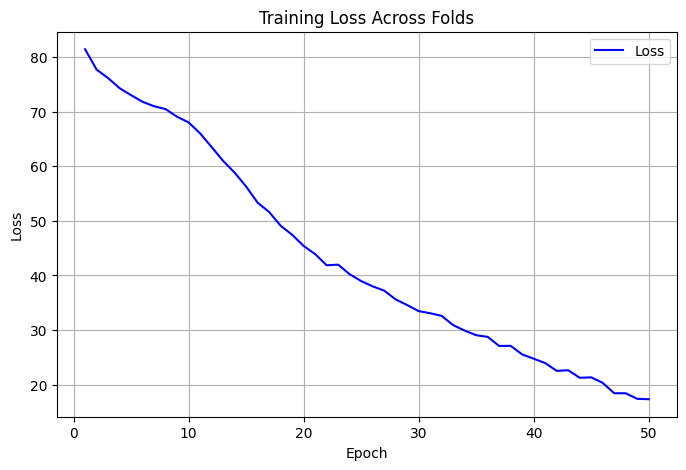

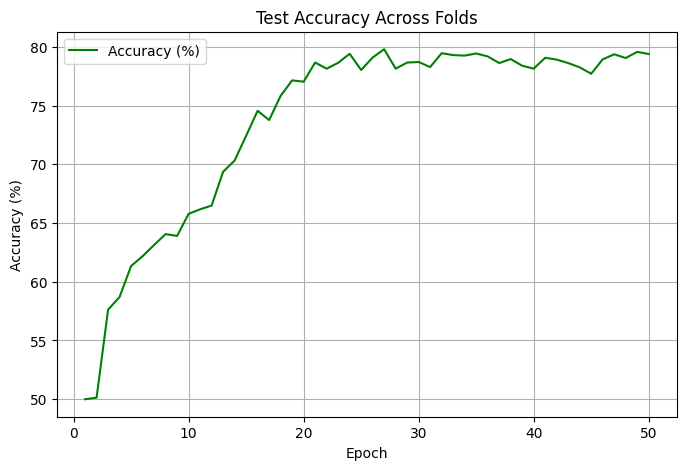

In [ ]:
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=1e-4, feature_method='raw', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv2d(


Epoch 1/50, Loss: 81.2371, Test Acc: 0.5000
Epoch 2/50, Loss: 78.2191, Test Acc: 0.5635
Epoch 3/50, Loss: 76.7336, Test Acc: 0.5136
Epoch 4/50, Loss: 71.7414, Test Acc: 0.6542
Epoch 5/50, Loss: 62.8126, Test Acc: 0.7302
Epoch 6/50, Loss: 57.3357, Test Acc: 0.7200
Epoch 7/50, Loss: 53.6005, Test Acc: 0.7098
Epoch 8/50, Loss: 52.3993, Test Acc: 0.7574
Epoch 9/50, Loss: 49.2179, Test Acc: 0.7358
Epoch 10/50, Loss: 47.3821, Test Acc: 0.7517
Epoch 11/50, Loss: 46.0482, Test Acc: 0.7585
Epoch 12/50, Loss: 44.6782, Test Acc: 0.7596
Epoch 13/50, Loss: 42.7222, Test Acc: 0.7868
Epoch 14/50, Loss: 41.6825, Test Acc: 0.7778
Epoch 15/50, Loss: 40.7051, Test Acc: 0.7857
Epoch 16/50, Loss: 40.5800, Test Acc: 0.7744
Epoch 17/50, Loss: 39.8524, Test Acc: 0.7744
Epoch 18/50, Loss: 39.4278, Test Acc: 0.7755
Epoch 19/50, Loss: 36.9863, Test Acc: 0.7789
Epoch 20/50, Loss: 36.3258, Test Acc: 0.8084
Epoch 21/50, Loss: 35.9692, Test Acc: 0.7834
Epoch 22/50, Loss: 34.7152, Test Acc: 0.7914
Epoch 23/50, Loss: 

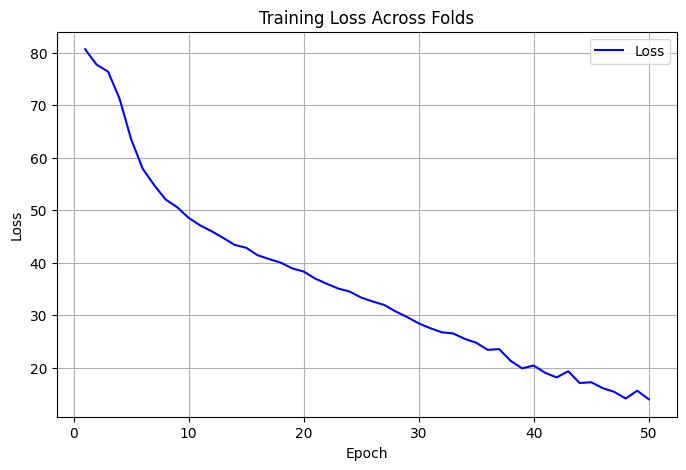

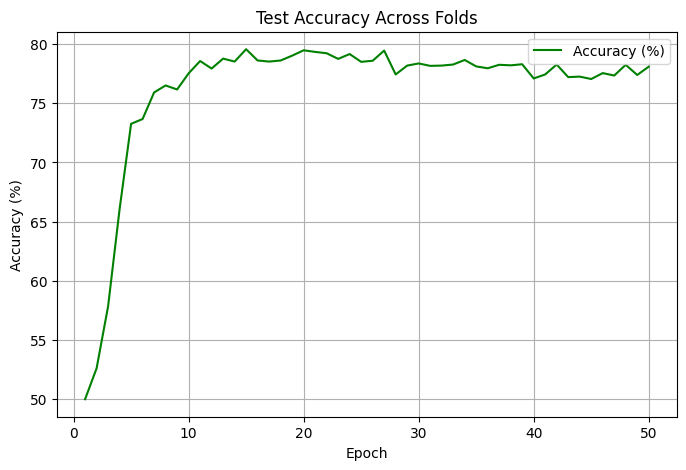

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=1e-4, feature_method='raw', subject_data= subject_data_preload)

In [ ]:
#-------------------------------------------------------------------------------------


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)
Epoch 1/50, Loss: 78.4524, Test Acc: 0.5000
Epoch 2/50, Loss: 76.3068, Test Acc: 0.5102
Epoch 3/50, Loss: 73.9673, Test Acc: 0.5624
Epoch 4/50, Loss: 73.7421, Test Acc: 0.5612
Epoch 5/50, Loss: 72.1578, Test Acc: 0.5703
Epoch 6/50, Loss: 71.4118, Test Acc: 0.5714
Epoch 7/50, Loss: 70.2009, Test Acc: 0.5771
Epoch 8/50, Loss: 69.6551, Test Acc: 0.5669
Epoch 9/50, Loss: 68.1349, Test Acc: 0.6054
Epoch 10/50, Loss: 68.8073, Test Acc: 0.5884
Epoch 11/50, Loss: 67.9501, Test Acc: 0.5839
Epoch 12/50, Loss: 66.6385, Test Acc: 0.5907
Epoch 13/50, Loss: 66.9416, Test Acc: 0.6202
Epoch 14/50, Loss: 66.5358, Test Acc: 0.6088
Epoch 15/50, Loss: 64.8436, Test Acc: 0.6100
Epoch 16/50, Loss: 65.3304, Test Acc: 0.6054
Epoch 17/50, Loss: 63.8967, Test Acc: 0.6202
Epoch 18/50, Loss: 63.0214, Test Acc: 0.6156
Epoch 19/50, Loss: 62.2477, Test Acc: 0.6293
Epoch 20/50, Loss: 60.7850, Test Acc: 0.6451
Epoch 21/50, Loss: 60.0137, Test Acc: 0.6247
Epoch 22/50, L

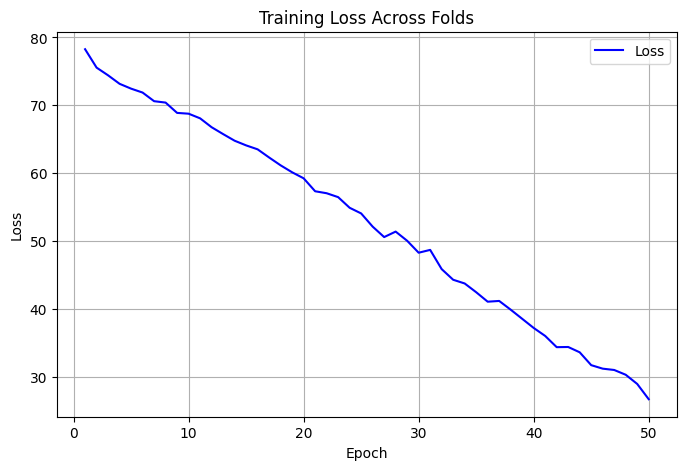

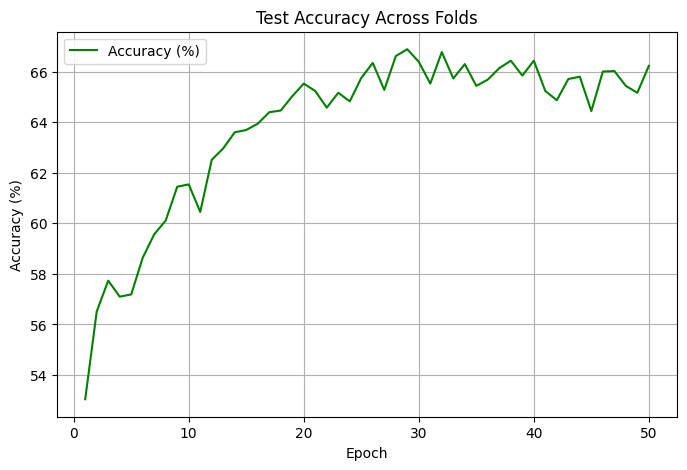

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=1e-4, feature_method='stft', subject_data= subject_data_preload)

Precomputing wavelet features for all subjects...
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat

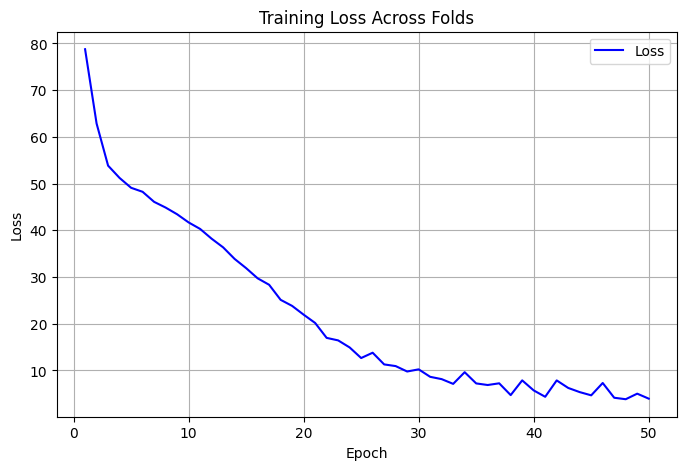

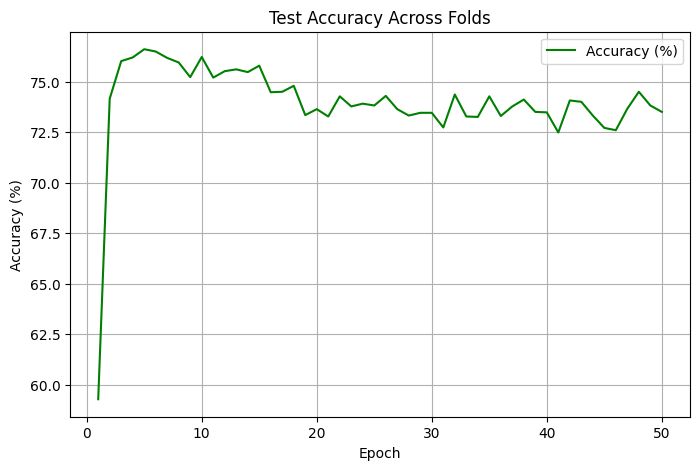

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=1e-4, feature_method='wavelet', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Fitting CSP on training data...
Computing rank from data with rank=None
    Using tolerance 1.2e+02 (2.2e-16 eps * 64 dim * 8.2e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using SHRINKAGE
Done.
Estimating class=1 covariance using SHRINKAGE
Done.
Epoch 1/50, Loss: 73.4407, Test Acc: 0.7166
Epoch 2/50, Loss: 57.1162, Test Acc: 0.7222
Epoch 3/50, Loss: 53.4709, Test Acc: 0.7381
Epoch 4/50, Loss: 49.2547, Test Acc: 0.7109
Epoch 5/50, Loss: 47.5303, Test Acc: 0.7234
Epoch 6/50, Loss: 45.0486, Test Acc: 0.7222
Epoch 7/50, Loss: 38.5347, Test Acc: 0.7177
Epoch 8/50, Loss: 33.8155, Test Acc: 0.7098
Epoch 9/50, Loss: 32.6645, Test Acc: 0.7018
Epoch 10/50, Loss: 27.7941, Test Acc: 0.7154
Epoch 11/50, Loss: 27.5169, Test Acc: 0.6916
Epoch 12/50, Loss: 20.8072, Test Acc: 0.7052
Epoch 13/50, Loss: 17.4638, Test

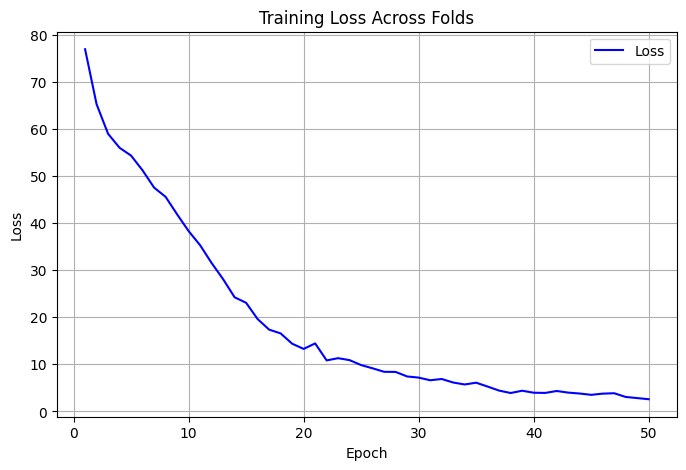

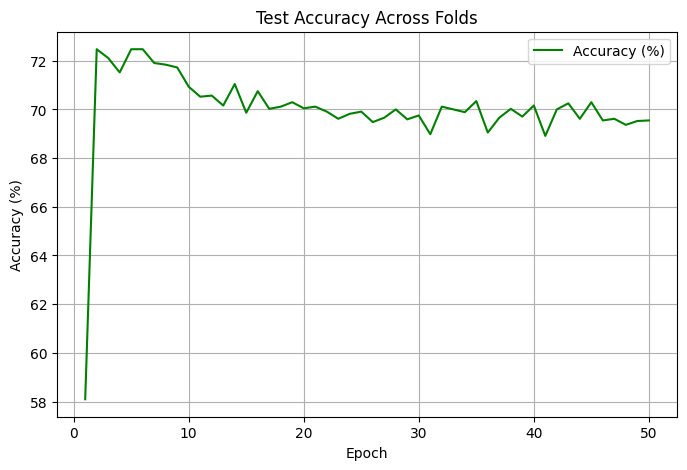

In [ ]:
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=7e-3, feature_method='csp', subject_data= subject_data_preload)

Precomputing wavelet features for all subjects...
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat

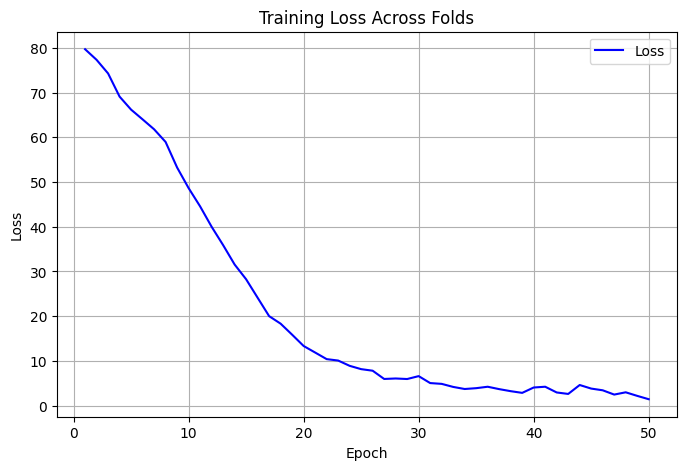

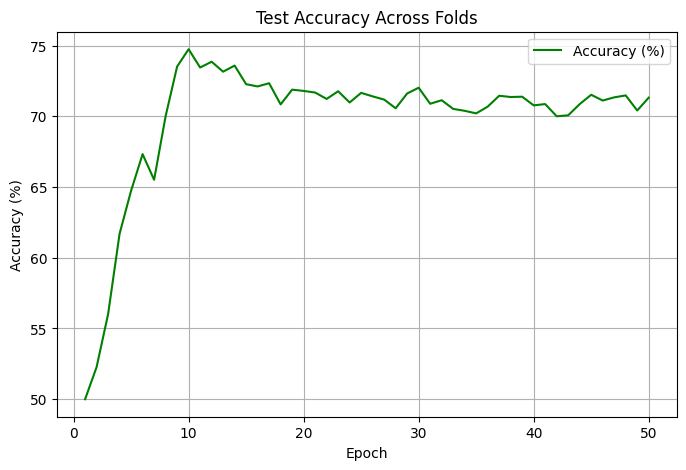

In [ ]:
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=1e-3, feature_method='wavelet', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Fitting CSP on training data...
Computing rank from data with rank=None
    Using tolerance 1.2e+02 (2.2e-16 eps * 64 dim * 8.2e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using SHRINKAGE
Done.
Estimating class=1 covariance using SHRINKAGE
Done.
Epoch 1/50, Loss: 66.8066, Test Acc: 0.6723
Epoch 2/50, Loss: 62.3570, Test Acc: 0.6973
Epoch 3/50, Loss: 59.9944, Test Acc: 0.6995
Epoch 4/50, Loss: 55.3622, Test Acc: 0.7018
Epoch 5/50, Loss: 51.8938, Test Acc: 0.7063
Epoch 6/50, Loss: 47.3655, Test Acc: 0.6950
Epoch 7/50, Loss: 42.8833, Test Acc: 0.6995
Epoch 8/50, Loss: 39.0124, Test Acc: 0.6791
Epoch 9/50, Loss: 34.9774, Test Acc: 0.6780
Epoch 10/50, Loss: 31.2303, Test Acc: 0.6848
Epoch 11/50, Loss: 27.8954, Test Acc: 0.6678
Epoch 12/50, Loss: 23.3231, Test Acc: 0.6848
Epoch 13/50, Loss: 21.9052, Test

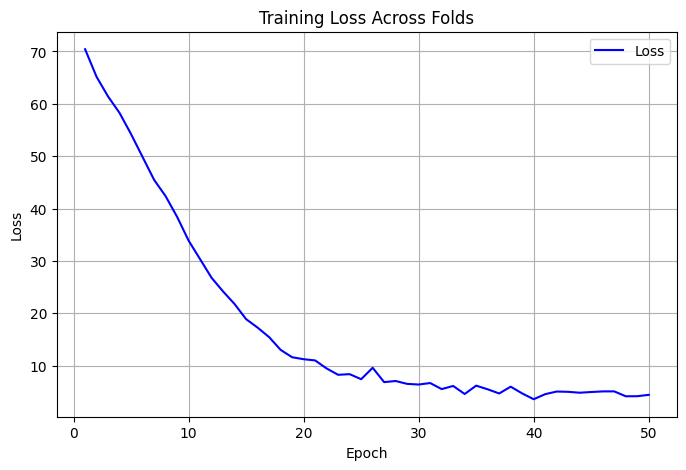

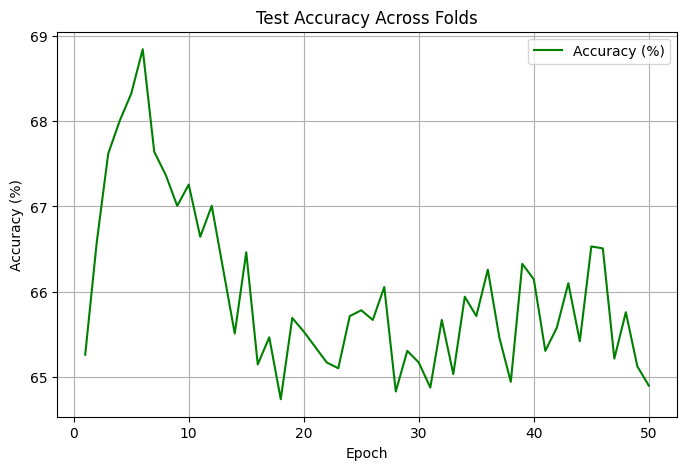

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=7e-3, feature_method='csp', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Fitting CSP on training data...
Computing rank from data with rank=None
    Using tolerance 1.2e+02 (2.2e-16 eps * 64 dim * 8.2e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using SHRINKAGE
Done.
Estimating class=1 covariance using SHRINKAGE
Done.
Epoch 1/50, Loss: 79.4586, Test Acc: 0.6565
Epoch 2/50, Loss: 68.1883, Test Acc: 0.6621
Epoch 3/50, Loss: 65.2606, Test Acc: 0.6780
Epoch 4/50, Loss: 62.9476, Test Acc: 0.6474
Epoch 5/50, Loss: 62.0884, Test Acc: 0.6848
Epoch 6/50, Loss: 61.3888, Test Acc: 0.7018
Epoch 7/50, Loss: 58.9519, Test Acc: 0.6825
Epoch 8/50, Loss: 59.4324, Test Acc: 0.7041
Epoch 9/50, Loss: 58.1014, Test Acc: 0.7177
Epoch 10/50, Loss: 57.8950, Test Acc: 0.6655
Epoch 11/50, Loss: 57.6768, Test Acc: 0.7063
Epoch 12/50, Loss: 57.3408, Test Acc: 0.7154
Epoch 13/50, Loss: 57.0595, Test

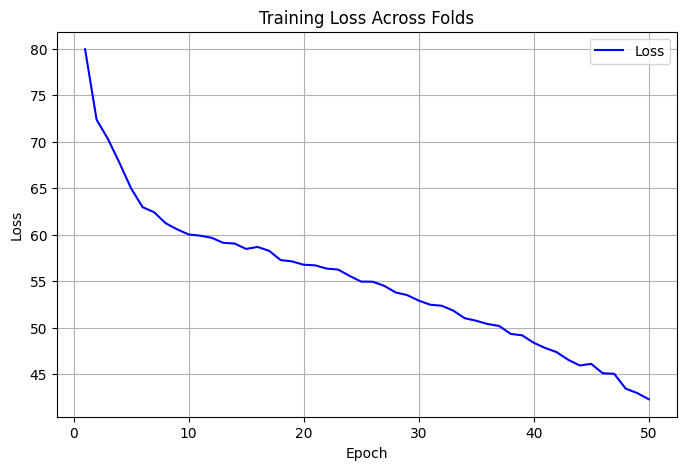

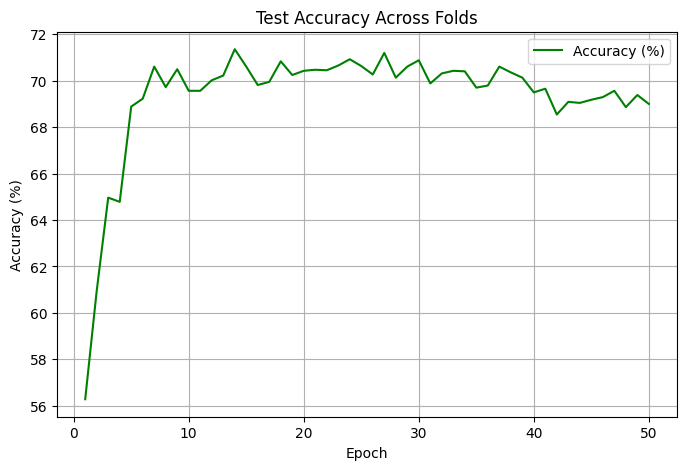

In [ ]:
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=7e-4, feature_method='csp', subject_data= subject_data_preload)

In [ ]:
import os
import pandas as pd
import re
import numbers

input_folder = f'/content/drive/My Drive/EEG_Data/Physionet/{WINDOW_SIZE}'
output_folder = f'/content/drive/My Drive/EEG_Data/Physionet/separate_results/{WINDOW_SIZE}'
os.makedirs(output_folder, exist_ok=True)

csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]
summaries = {method: [] for method in ['raw', 'cnn', 'csp', 'stft', 'wavelet']}

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

for file in csv_files:
    filepath = os.path.join(input_folder, file)

    # Examples:
    # fold_cross_subject_accuracies_TemporalCNNTransformer_stft_nfft128_hop32_0.0001.csv
    # fold_cross_subject_accuracies_TemporalCNNTransformer_wavelet_db6_levels3_0.0001.csv
    # fold_cross_subject_accuracies_TemporalCNNTransformer_raw_0.0007.csv
    # fold_cross_subject_accuracies_TemporalCNNTransformer_cnn_0.007.csv
    # fold_cross_subject_accuracies_TemporalCNNTransformer_csp_numcomp6_0.007.csv

    base_name = file[:-4]
    parts = base_name.split('_')

    try:
        model_idx = parts.index('accuracies') + 1
        model_name = parts[model_idx]
        feature_method = parts[model_idx + 1]
    except (ValueError, IndexError):
        print(f"Cannot parse model and feature method in {file}")
        continue

    params = {}
    learning_rate = None
    learning_rate = next((part for part in reversed(parts) if re.match(r'^[\d\.]+$', part)), None)

    if feature_method == 'raw' or feature_method == 'cnn':
        pass

    elif feature_method == 'stft':
        for p in parts:
            if p.startswith('nfft'):
                params['nfft'] = p.replace('nfft', '')
            if p.startswith('hop'):
                params['hop'] = p.replace('hop', '')

    elif feature_method == 'wavelet':
        wavelet_index = parts.index('wavelet')
        next_part = parts[wavelet_index + 1] if wavelet_index + 1 < len(parts) else None
        if next_part is not None and not is_number(next_part):
            params['wavelet_type'] = next_part
        else:
            params['wavelet_type'] = "-"

    elif feature_method == 'csp':
        for p in parts:
            if p.startswith('numcomp'):
                params['num_components'] = p.replace('numcomp', '')
            if p.startswith('patchsize'):
                params['patch_size'] = p.replace('patchsize', '')


    df = pd.read_csv(filepath)
    if 'Accuracy' not in df.columns:
        print(f"No Accuracy column in {file}, skipping")
        continue

    mean_acc = df['Accuracy'].mean()
    mean_acc = round(mean_acc, 2)

    summary = {
        'Model': model_name,
        'Feature_Method': feature_method,
        'Learning_Rate': learning_rate,
        'Average_Accuracy(%)': mean_acc,
    }
    summary.update(params)
    summaries[feature_method].append(summary)

for method, rows in summaries.items():
    if rows:
        df_summary = pd.DataFrame(rows)

        df_summary = df_summary.sort_values(by=['Model', 'Average_Accuracy(%)'], ascending=[True, False])
        df_summary.to_csv(os.path.join(output_folder, f'{method}_summary.csv'), index=False)
        print(f"Saved summary for {method} with {len(rows)} entries")
    else:
        print(f"No data for feature method: {method}")

Cannot parse model and feature method in cross_subject_accuracies.csv
Cannot parse model and feature method in subject_accuracies.csv
Cannot parse model and feature method in fold_cross_subject_accuracies.csv
Cannot parse model and feature method in fold_cross_subject_accuracies_TemporalCNNTransformer.csv
Cannot parse model and feature method in fold_cross_subject_accuracies_FusionCNNTransformer.csv
Cannot parse model and feature method in fold_cross_subject_accuracies_SpatialTransformer.csv
Cannot parse model and feature method in fold_cross_subject_accuracies_SpatialCNNTransformer.csv
Cannot parse model and feature method in subject_accuracies_SpatialTransformer.csv
Saved summary for raw with 7 entries
Saved summary for cnn with 5 entries
Saved summary for csp with 37 entries
Saved summary for stft with 17 entries
Saved summary for wavelet with 17 entries


In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=7e-3, feature_method='csp', subject_data= subject_data_preload)

In [ ]:
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=1e-4, feature_method='stft', subject_data= subject_data_preload)

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=1e-3, feature_method='stft', subject_data= subject_data_preload)